In [13]:
import pandas as pd
from Preprocess import * 
from FeatureExtraction import *
from plotting import *
from tqdm import tqdm 

In [2]:
df = pd.read_csv('data/WELFake_Dataset.csv')

df.drop(df.columns[0], axis=1, inplace=True)
df.dropna(inplace=True)

df = df.sample(n=5000, random_state=42)

print(df['label'].value_counts())

X=df.drop(['label'],axis=1)
y=df['label']
print(X.shape)
print(y.shape)

1    2523
0    2477
Name: label, dtype: int64
(5000, 2)
(5000,)


In [3]:
# df = pd.read_csv('data/news_articles.csv')

# df.dropna(inplace=True)
# df.drop(df[df['language'] != 'english'].index,inplace=True)
# df=df.drop(['published','main_img_url','type','language','title_without_stopwords','text_without_stopwords'],axis=1)


# print(df['label'].value_counts())

# X=df.drop(['label'],axis=1)
# y=df['label']
# print(X.shape)
# print(y.shape)


In [3]:
X.head()

,title,text
54359,Live at Truthdig: Robert Scheer and Thomas Fra...,Live at Truthdig: Robert Scheer and Thomas Fra...
6993,The Mirage of a Return to Manufacturing Greatn...,"Half a century ago, harvesting California’s 2...."
28912,British PM expected to offer to fill post-Brex...,(Reuters) - The British government has told Ge...
65965,Checkmating Obama,Originally published by the Jerusalem Post . \...
2307,Thirty-eight injured in police charges in Cata...,MADRID (Reuters) - Emergency services have att...


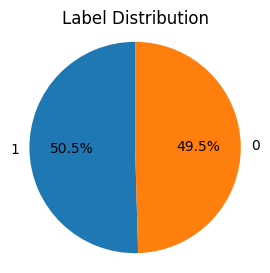

In [4]:
import matplotlib.pyplot as plt

label_counts = y.value_counts()

plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()


In [5]:
X['preprocessed_text'] = preprocess_text(X['text'])
print(X['preprocessed_text'].head(3))


54359    live truthdig robert scheer thomas frank talk ...
6993     half century ago harvesting california million...
28912    reuters british government told german chancel...
Name: preprocessed_text, dtype: object


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X['preprocessed_text'], y, test_size=0.2, random_state=42)

ngram_ranges = [(1, 1), (2, 2)]

classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    RandomForestClassifier(),
    SVC()
]

for ngram_range in tqdm(ngram_ranges):
    metrics_dict = {}
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    for classifier in tqdm(classifiers):
        classifier_name = classifier.__class__.__name__
        classifier_metrics = []

        classifier.fit(X_train_tfidf, y_train)
        y_pred = classifier.predict(X_test_tfidf)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        classifier_metrics.extend([accuracy, precision, recall, f1])
        metrics_dict[classifier_name] = classifier_metrics

    print(f"{ngram_range}-gram")
    for classifier_name, classifier_metrics in metrics_dict.items():
        print(f"{classifier_name}: {classifier_metrics}")


 50%|█████     | 1/2 [00:31<00:31, 31.04s/it]

(1, 1)-gram
LogisticRegression: [0.912, 0.9094567404426559, 0.9131313131313131, 0.9112903225806452]
MultinomialNB: [0.854, 0.8921348314606742, 0.802020202020202, 0.8446808510638297]
RandomForestClassifier: [0.885, 0.897489539748954, 0.8666666666666667, 0.881808838643371]
SVC: [0.916, 0.9101796407185628, 0.9212121212121213, 0.9156626506024097]


100%|██████████| 2/2 [01:57<00:00, 58.66s/it]

(2, 2)-gram
LogisticRegression: [0.889, 0.8824701195219123, 0.8949494949494949, 0.8886659979939819]
MultinomialNB: [0.874, 0.9382422802850356, 0.797979797979798, 0.8624454148471615]
RandomForestClassifier: [0.875, 0.8530534351145038, 0.9030303030303031, 0.8773307163886164]
SVC: [0.889, 0.8779527559055118, 0.901010101010101, 0.8893320039880358]


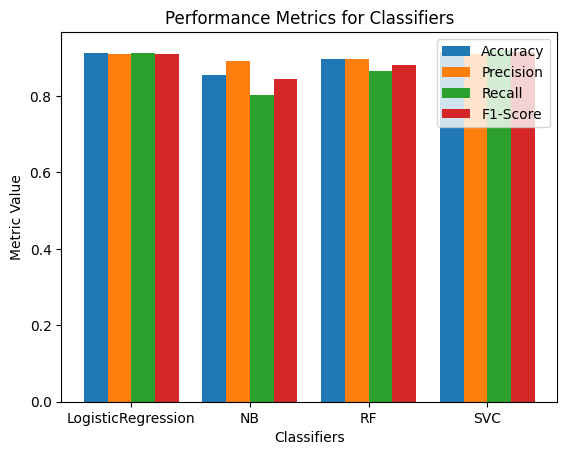

In [6]:
# plot_accuracy_graph(["LR","NB","RF","SVM"],[0.912,0.854,0.897,0.916])
metrics([0.912,0.854,0.897,0.916],[0.909,0.892,0.897,0.910],[0.913,0.802,0.866,0.921],[0.911,0.844,0.88,0.915])

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

X_k = X['preprocessed_text']
y_k = np.array(y)

ngram_ranges = [(1, 1), (2, 2)]

classifiers = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    RandomForestClassifier(),
    SVC()
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

metrics_dict = {}

for classifier in classifiers:
    classifier_name = classifier.__class__.__name__
    classifier_metrics = []

    for ngram_range in ngram_ranges:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        X_tfidf = vectorizer.fit_transform(X_k)

        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []

        for train_index, test_index in kf.split(X_tfidf):
            X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
            y_train, y_test = y_k[train_index], y_k[test_index]

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        mean_accuracy = np.mean(accuracies)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(f1_scores)

        classifier_metrics.append((mean_accuracy, mean_precision, mean_recall, mean_f1))

    metrics_dict[classifier_name] = classifier_metrics

for ngram_range in ngram_ranges:
    print(f"{ngram_range}-gram")
    for classifier_name, classifier_metrics in metrics_dict.items():
        print(f"{classifier_name}: {classifier_metrics}")


(1, 1)-gram
LogisticRegression: [(0.891, 0.870168418334029, 0.9218951513149772, 0.8951432785555378), (0.8512000000000001, 0.7983347082640367, 0.9432239842399367, 0.8646673582714428)]
MultinomialNB: [(0.8257999999999999, 0.8639549846202323, 0.7783824113764803, 0.8183396231943803), (0.85, 0.8938842893978854, 0.7978517803562755, 0.8429899560975471)]
RandomForestClassifier: [(0.8837999999999999, 0.8871408238802927, 0.882348785439597, 0.8846101055204272), (0.8644000000000001, 0.8174796074963074, 0.9415056020473432, 0.8750712550481815)]
SVC: [(0.9004, 0.8805025686954095, 0.9290279446445565, 0.904017103142418), (0.8538, 0.8001847988425123, 0.9464092399220266, 0.8670952031870097)]
(2, 2)-gram
LogisticRegression: [(0.891, 0.870168418334029, 0.9218951513149772, 0.8951432785555378), (0.8512000000000001, 0.7983347082640367, 0.9432239842399367, 0.8646673582714428)]
MultinomialNB: [(0.8257999999999999, 0.8639549846202323, 0.7783824113764803, 0.8183396231943803), (0.85, 0.8938842893978854, 0.79785178

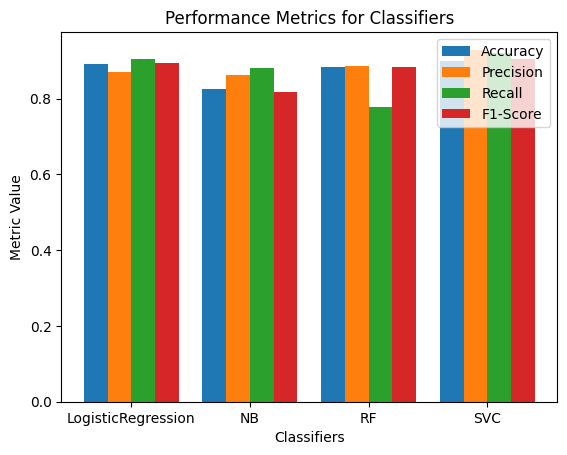

In [9]:
metrics([0.891,0.825,0.883,0.900],[0.870,0.863,0.887,0.929],[0.904,0.882,0.778,0.921],[0.895,0.818,0.884,0.904])

In [11]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

sentences = [text.split() for text in X['preprocessed_text']]
word2vec_model = Word2Vec(sentences, min_count=1, vector_size=100)

X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

ngram_ranges = [(1, 1), (2, 2)]

classifiers = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    SVC()
]

metrics_dict = {}

for ngram_range in ngram_ranges:
    ngram_metrics = {}
    
    X_train_word_vectors = np.array([np.mean([word2vec_model.wv[w] for w in words if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in X_train])
    X_test_word_vectors = np.array([np.mean([word2vec_model.wv[w] for w in words if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in X_test])
    
    X_train_normalized = preprocessing.normalize(X_train_word_vectors, norm='l2')
    X_test_normalized = preprocessing.normalize(X_test_word_vectors, norm='l2')

    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        classifier_metrics = []

        classifier.fit(X_train_normalized, y_train)
        y_pred = classifier.predict(X_test_normalized)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        classifier_metrics.extend([accuracy, precision, recall, f1])
        ngram_metrics[classifier_name] = classifier_metrics

    metrics_dict[ngram_range] = ngram_metrics

for ngram_range, ngram_metrics in metrics_dict.items():
    print(f"n-gram range {ngram_range}:")
    for classifier_name, classifier_metrics in ngram_metrics.items():
        print(f"{classifier_name}: {classifier_metrics}")


n-gram range (1, 1):
LogisticRegression: [0.842, 0.8431771894093686, 0.8363636363636363, 0.8397565922920891]
RandomForestClassifier: [0.843, 0.83399209486166, 0.8525252525252526, 0.8431568431568431]
SVC: [0.861, 0.8531746031746031, 0.8686868686868687, 0.8608608608608609]
n-gram range (2, 2):
LogisticRegression: [0.842, 0.8431771894093686, 0.8363636363636363, 0.8397565922920891]
RandomForestClassifier: [0.853, 0.8411764705882353, 0.8666666666666667, 0.853731343283582]
SVC: [0.861, 0.8531746031746031, 0.8686868686868687, 0.8608608608608609]


In [14]:
metrics2([0.842,0.843,0.861],[0.843,0.833,0.853],[0.836,0.852,0.868],[0.839,0.843,0.860])

NameError: name 'metrics2' is not defined

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

voc_size=3000
onehot_repr=[one_hot(words,voc_size)for words in X['preprocessed_text']]

sentence_len=40
embedded_doc = pad_sequences(onehot_repr,padding='pre',maxlen=sentence_len)

embedding_vec_feature=150
model=Sequential()
model.add(Embedding(voc_size,embedding_vec_feature,input_length=sentence_len))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())




X_f=np.array(embedded_doc)
y_f=np.array(y)
print(X_f.shape)
print(y_f.shape)


X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=42)

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)



In [ ]:
# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.text import one_hot
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Define hyperparameters for grid search
# voc_size = [1000, 2000, 3000]  # Vocabulary size
# sentence_len = [20, 30, 40]  # Maximum sentence length
# embedding_vec_feature = [50, 100, 150]  # Dimensionality of word embeddings

# # Perform grid search
# best_accuracy = 0.0
# best_params = {}

# for vs in voc_size:
#     for sl in sentence_len:
#         for evf in embedding_vec_feature:
#             onehot_repr = [one_hot(words, vs) for words in X['preprocessed_text']]
#             embedded_doc = pad_sequences(onehot_repr, padding='pre', maxlen=sl)
            
#             model = Sequential()
#             model.add(Embedding(vs, evf, input_length=sl))
#             model.add(Dropout(0.6))
#             model.add(LSTM(100))
#             model.add(Dense(1, activation='sigmoid'))
#             model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            
#             X_f = np.array(embedded_doc)
#             y_f = np.array(y)
            
#             X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=42)
            
#             model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, verbose=0)
            
#             y_pred_prob = model.predict(X_test)
#             y_pred = np.round(y_pred_prob).astype(int)
#             accuracy = accuracy_score(y_test, y_pred)
            
#             print(f"voc_size={vs}, sentence_len={sl}, embedding_vec_feature={evf}: Accuracy = {accuracy}")
            
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_params = {'voc_size': vs, 'sentence_len': sl, 'embedding_vec_feature': evf}

# # Print best parameters
# print("Best Parameters:", best_params)
